# WCPDT Peptide Alignment
Here we apply the final filter for our peptides by aligning our peptide list to known proteome database for a final checkup.

In [1]:
from Bio import SeqIO
import gzip
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# 20mer Splits
First we split our peptides into 20mers and use the 20mer with the highest alignment rate as the peptide's representative/overall alignment score.

In [2]:
#Split proteins into chunks of 20
new_file = "results/filtered_orphan_peptide_20mers.fa"
kmer = 20

with open(new_file, "w") as new_fa:
    for record in SeqIO.parse("results/filtered_orphan_peptide_ORFs.fa", "fasta"):
        kmer_count = 0
        for i in np.arange(0,len(record.seq),kmer):
            seq = str(record.seq[i:i+kmer])
            if len(seq) < kmer: #Aidan mentioned he just discard the tail ends that are smaller than 20AA
                continue 
            elif len(seq) >= kmer:
                new_fa.write('>' + record.id + '_kmer_' + str(kmer_count) + '\n')
                new_fa.write(str(record.seq[i:i+kmer]) + '\n')
            kmer_count += 1  

# Peptide Alignment to Proteome
Our last step is to align these peptides using BLAST and eliminate peptides with high alignment rates to known proteome. To do this we used the blastp function from the BLAST+ tool.

In [6]:
%%bash
/rumi/shams/jwang/bin/ncbi-blast-2.11.0+/bin/blastp -query results/filtered_orphan_peptide_20mers.fa \
-db /rumi/shams/jwang/bin/ncbi-blast-2.11.0+/bin/swissprot \
-task blastp-short \
-outfmt 10 \
-out results/filtered_orphan_peptide_20mer_blast.csv \
-num_alignments 5 \
-num_descriptions 5 \
-taxids 9606 

In [10]:
#saccver = Subject accession.version, pident = Percentage of identical matches, 
header = ['id', 'saccver', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore']
blast_results = pd.read_csv("results/filtered_orphan_peptide_20mer_blast.csv", names=header)
print(len(blast_results["id"].unique()))
blast_results.shape

3019


(12824, 12)

In [9]:
blast_results.head(3)

,id,saccver,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,gene.57.0.1-x2-14_kozak_0_kmer_0,Q9H252.1,87.500,8,1,0,13,20,718,725,3.9,23.5
1,gene.57.0.1-x2-14_kozak_0_kmer_0,A8K2U0.3,47.059,17,3,1,3,19,1076,1086,6.8,23.1
2,gene.57.0.1-x2-14_kozak_0_kmer_0,Q9HCM7.4,87.500,8,1,0,13,20,871,878,7.8,22.7


In [11]:
#aggregate multiple alignments into maximum chunk
grouped_blast = blast_results.groupby('id', as_index=False).agg({'bitscore':'max'}) #Get the maximum bitscore for each group (merge multiple hits)!
grouped_blast = grouped_blast.set_index('id')
print(grouped_blast.shape)
grouped_blast.head(3)

(3019, 1)


,bitscore
id,
gene.10020.301.1-x0-36_kozak_1_kmer_0,25.7
gene.10020.301.1-x0-36_kozak_1_kmer_1,24.0
gene.10020.301.1-x0-36_kozak_1_kmer_2,25.2


In [14]:
#Aggregate kmers into max bitscore for each orf
grouped_blast['orf_id'] = [x.split('_kmer')[0] for x in grouped_blast.index]
final_blast = grouped_blast.groupby('orf_id', as_index=False).agg({'bitscore':'max'}) #Get the maximum bitscore for each group (orf)
print(final_blast.shape)
final_blast.head(3)

(1406, 2)


,orf_id,bitscore
0,gene.10020.301.1-x0-36_kozak_1,25.7
1,gene.10055.109.0-x0-19_kozak_0,26.5
2,gene.1008.233.3-x2-32_kozak_1,29.5


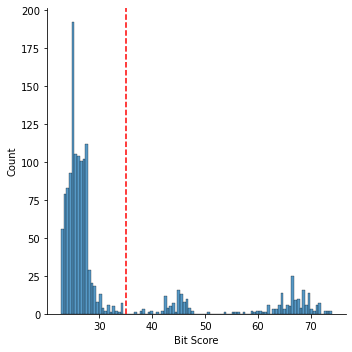

0.8129445234708392


In [17]:
sns.displot(final_blast["bitscore"], bins=100)
plt.xlabel("Bit Score")
plt.axvline(35, linestyle='--', c='red')
plt.show()

print(np.sum(final_blast.bitscore < 35) / len(final_blast.bitscore))

We want to keep peptides with low bitscore or alignments to the known proteome.

In [19]:
filtered_orfs = pd.read_csv("results/filtered_orphan_peptide_ORFs_meta.csv", index_col=0)
filtered_orfs.head(3)

,score,ORFlength,ORFIDinTranscript,totalNumORFinTranscript,tx,kozak_id,median_tpm,mean_tpm
0,9.611,69,0,3,gene.57.0.1-x2-14,gene.57.0.1-x2-14_kozak_0,2.326552,2.808074
1,10.466,342,0,1,gene.29.1159.6-x1-23,gene.29.1159.6-x1-23_kozak_0,1.971496,2.502299
2,10.466,165,0,3,gene.81.2.2-x0-1,gene.81.2.2-x0-1_kozak_0,2.378656,3.104456


In [20]:
final_filtered_orfs = pd.merge(filtered_orfs, final_blast, how="inner", left_on="kozak_id", right_on="orf_id")
print(final_filtered_orfs.shape)
final_filtered_orfs.head(3)

(1406, 10)


,score,ORFlength,ORFIDinTranscript,totalNumORFinTranscript,tx,kozak_id,median_tpm,mean_tpm,orf_id,bitscore
0,9.611,69,0,3,gene.57.0.1-x2-14,gene.57.0.1-x2-14_kozak_0,2.326552,2.808074,gene.57.0.1-x2-14_kozak_0,23.5
1,10.466,342,0,1,gene.29.1159.6-x1-23,gene.29.1159.6-x1-23_kozak_0,1.971496,2.502299,gene.29.1159.6-x1-23_kozak_0,46.0
2,10.466,165,0,3,gene.81.2.2-x0-1,gene.81.2.2-x0-1_kozak_0,2.378656,3.104456,gene.81.2.2-x0-1_kozak_0,46.0


In [22]:
final_filtered_orfs = final_filtered_orfs[final_filtered_orfs["bitscore"] <= 35]
final_filtered_orfs.shape

(1143, 10)

In [23]:
final_filtered_orfs_id = set(final_filtered_orfs["kozak_id"])
len(final_filtered_orfs_id)

1143

In [24]:
#Save Files
with open("results/final_filtered_orphan_peptide_ORFs.fa", "w") as out:
    for record in SeqIO.parse("results/orphan_peptide_ORFs.fa", "fasta"): #From original file with kozak sequence within
        if record.id not in final_filtered_orfs_id:
            continue
        peptide = str(record.seq[4:].translate()) #This is to offset the 4 nucleotides from the Kozak sequence.
        split_peptide = re.sub("(.{60})", "\\1\n", peptide, count=0, flags=re.DOTALL)
        out.write('>' + record.id + '\n' + split_peptide + '\n')
final_filtered_orfs.to_csv("results/final_filtered_orphan_peptide_ORFs_meta.csv", index=None)

Final list we have 1143 peptides.

# Done